# hpiPy Introduction

In [1]:
import pathlib, sys
sys.path.insert(1, str(pathlib.Path().resolve().parents[0]))

In [2]:
import copy

import numpy as np
import pandas as pd

from hpipy.extensions import GraphNeuralNetworkIndex, NeuralNetworkIndex, RandomForestIndex
from hpipy.period_table import PeriodTable
from hpipy.price_index import HedonicIndex, RepeatTransactionIndex
from hpipy.price_model import HedonicModel, RepeatTransactionModel
from hpipy.trans_data import HedonicTransactionData, RepeatTransactionData
from hpipy.utils.metrics import accuracy, revision, series_accuracy, series_volatility, volatility
from hpipy.utils.plotting import (
    plot_index,
    plot_index_accuracy,
    plot_index_volatility,
    plot_series_revision,
    plot_series_volatility,
)

np.random.seed(0)

## Data

In [3]:
df_ex_sales = pd.read_csv('../data/ex_sales.csv', parse_dates=['sale_date'])

In [4]:
sales_hdata = PeriodTable(df_ex_sales).create_period_table(
    'sale_date',
    periodicity='monthly',
)

In [5]:
salesx_hdata = PeriodTable(df_ex_sales).create_period_table(
    'sale_date',
    periodicity='monthly',
    min_date='2009-12-01',
    max_date='2016-12-31',
)

In [6]:
salesx_hdata = PeriodTable(df_ex_sales).create_period_table(
    'sale_date',
    periodicity='monthly',
    min_date='2010-12-01',
    max_date='2015-12-31',
)

In [7]:
sales_hdata_clip = PeriodTable(df_ex_sales).create_period_table(
    'sale_date',
    periodicity='monthly',
    min_date='2010-12-01',
    max_date='2015-12-31',
    adj_type='clip',
)

In [8]:
sales_hdata.period_table.head()

,start_date,end_date,period,name
0,2010-01-01,2010-01-31 23:59:59.999999999,1,2010-Jan
1,2010-02-01,2010-02-28 23:59:59.999999999,2,2010-Feb
2,2010-03-01,2010-03-31 23:59:59.999999999,3,2010-Mar
3,2010-04-01,2010-04-30 23:59:59.999999999,4,2010-Apr
4,2010-05-01,2010-05-31 23:59:59.999999999,5,2010-May


## Repeat Transactions (Sales) Model

### Data Prep

In [9]:
sales_rtdata = RepeatTransactionData(sales_hdata).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
    min_period_dist=12,
)

In [10]:
sales_rtdata.trans_df.head()

,prop_id,period_1,period_2,price_1,price_2,trans_id1,trans_id2,pair_id
0,..0007600057,56,80,520000,625000,2014..23738,2016..28612,1
1,..0216000010,29,47,1063000,1300000,2012..12112,2013..36837,2
2,..0342000250,40,78,626800,751000,2013..11548,2016..17781,3
3,..0342000570,15,57,295000,429000,2011..4885,2014..27574,4
4,..0342000570,15,78,295000,607000,2011..4885,2016..18557,5


In [11]:
sales_rtdata_so = RepeatTransactionData(sales_hdata).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
    seq_only=True,
)

In [12]:
sales_rtdata_so.trans_df.head()

,prop_id,period_1,period_2,price_1,price_2,trans_id1,trans_id2,pair_id
0,..0007600057,56,80,520000,625000,2014..23738,2016..28612,1
1,..0216000010,29,47,1063000,1300000,2012..12112,2013..36837,2
2,..0342000250,40,78,626800,751000,2013..11548,2016..17781,3
518,..0342000570,15,57,295000,429000,2011..4885,2014..27574,4
520,..0342000570,57,78,429000,607000,2014..27574,2016..18557,5


### Modeling

In [13]:
rt_model = RepeatTransactionModel(sales_rtdata).fit(estimator='base', log_dep=True)

In [14]:
rt_full = RepeatTransactionModel(sales_rtdata).fit(estimator='base', log_dep=True)

### Index Creation

In [15]:
rt_index = RepeatTransactionIndex.from_model(rt_full, max_period=None)

In [16]:
rt_short = RepeatTransactionIndex.from_model(rt_full, max_period=50)

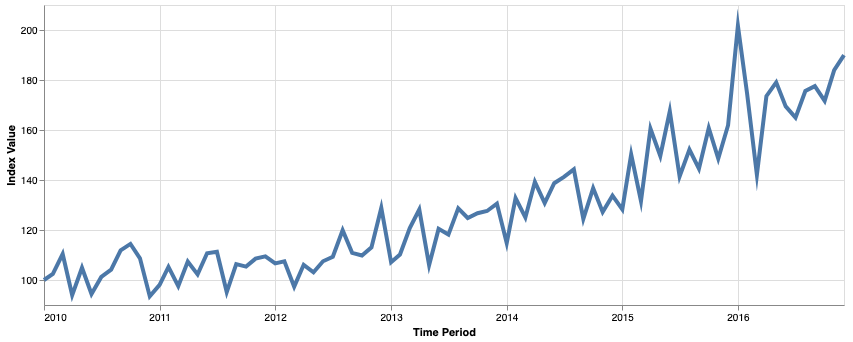

In [17]:
plot_index(rt_index)

In [18]:
rt_model_imp = copy.deepcopy(rt_full)
rt_model_imp.coefficients.loc[2:4, 'coefficient'] = np.nan

In [19]:
rt_model_imp = copy.deepcopy(rt_full)
rt_model_imp.coefficients.loc[2:4, 'coefficient'] = np.nan
rt_index_imp = RepeatTransactionIndex.from_model(rt_model_imp)
pd.DataFrame([rt_index_imp.value, rt_index_imp.imputed], index=['value', 'imputed']).T[:6]

,value,imputed
0,100.000000,0.0
1,102.453388,0.0
2,101.567375,1.0
3,98.361617,1.0
4,95.387672,1.0
5,94.433263,0.0


In [20]:
rt_model_imp = copy.deepcopy(rt_full)
rt_model_imp.coefficients.loc[[3, 6, 22, 54, 77, 82], 'coefficient'] = np.nan
rt_index_imp = RepeatTransactionIndex.from_model(rt_model_imp)

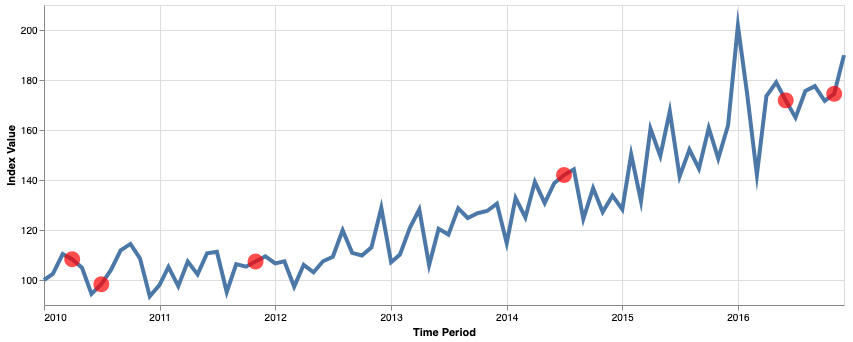

In [21]:
plot_index(rt_index_imp, show_imputed=True)

### Smoothing

In [22]:
rt_smooth = rt_index.smooth_index(order=5)

In [23]:
rt_smooth = rt_index.smooth_index(order=7, in_place=True)

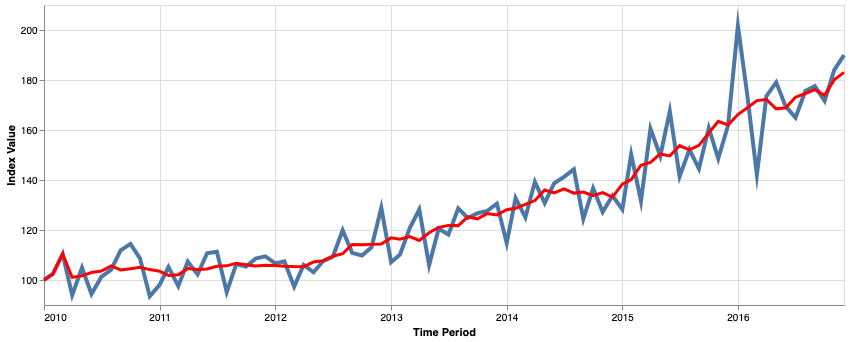

In [24]:
plot_index(rt_index, smooth=True)

### Data to Index Wrapper

In [25]:
rt_1 = RepeatTransactionIndex.create_index(
    trans_data=df_ex_sales,
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    seq_only=True,
    estimator='robust',
    log_dep=True,
    trim_model=True,
    max_period=48,
    smooth=False,
    periodicity='monthly',
    min_date='2010-06-01',
    max_date='2015-11-30',
    adj_type='clip',
    date='sale_date',
)

In [26]:
sales_hdata = PeriodTable(df_ex_sales).create_period_table(
    date='sale_date',
    periodicity='monthly',
)

rt_2 = RepeatTransactionIndex.create_index(
    trans_data=sales_hdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    seq_only=False,
    estimator='weighted',
    log_dep=False,
    trim_model=False,
    max_period=56,
    smooth=True,
)

In [27]:
sales_hdata = PeriodTable(df_ex_sales).create_period_table(
    date='sale_date',
    periodicity='monthly',
)

sales_rtdata = RepeatTransactionData(sales_hdata).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
)

rt_3 = RepeatTransactionIndex.create_index(
    trans_data=sales_rtdata,
    estimator='robust',
    log_dep=True,
    trim_model=False,
    max_period=80,
    smooth=True,
    smooth_order=5,
)

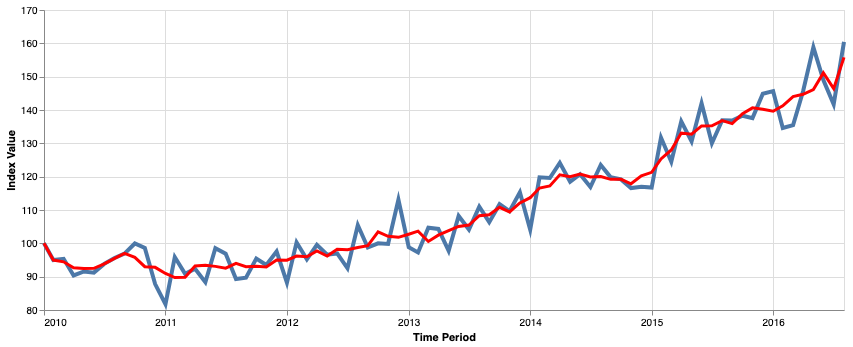

In [28]:
plot_index(rt_3, smooth=True)

## Hedonic Price Model

In [29]:
sales_hhdata = HedonicTransactionData(df_ex_sales).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
    date='sale_date',
    periodicity='monthly',
)

In [30]:
hed_model = HedonicModel(sales_hhdata).fit(
    estimator='base',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    log_dep=True,
)

In [31]:
hed_model_rob = HedonicModel(sales_hhdata).fit(
    estimator='robust',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    log_dep=True,
)

In [32]:
hed_model_wgt = HedonicModel(sales_hhdata).fit(
    estimator='weighted',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    log_dep=False,
    weights=np.random.uniform(0, 1, size=len(sales_hhdata.trans_df)),
 )

In [33]:
hed_index = HedonicIndex.from_model(hed_model)

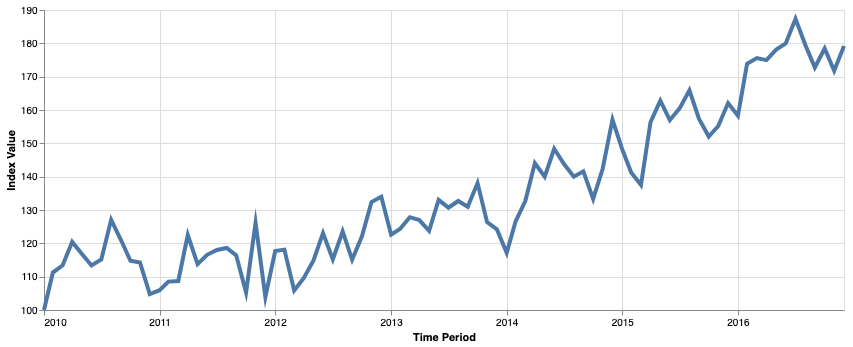

In [34]:
plot_index(hed_index)

In [35]:
hed_1 = HedonicIndex.create_index(
    trans_data=df_ex_sales,
    periodicity='monthly',
    min_date='2010-06-01',
    max_date='2015-11-30',
    adj_type='clip',
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    estimator='robust',
    log_dep=True,
    trim_model=True,
    max_period=48,
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    smooth=True,
)

In [36]:
sales_hdata = PeriodTable(df_ex_sales).create_period_table(
    date='sale_date',
    periodicity='monthly',
    min_date='2010-02-01',
    max_date='2015-11-30',
    adj_type='move',
)

In [37]:
hed_2 = HedonicIndex.create_index(
    trans_data=sales_hdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    estimator='base',
    log_dep=False,
    trim_model=False,
    max_period=56,
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    smooth=True,
)

In [38]:
sales_hhdata = HedonicTransactionData(sales_hdata).create_transactions(
    prop_id='pinx',
    trans_id='sale_id',
    price='sale_price',
)

In [39]:
hed_3 = HedonicIndex.create_index(
    trans_data=sales_hhdata,
    estimator='weighted',
    log_dep=True,
    trim_model=False,
    max_period=80,
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    weights=np.random.uniform(0, 1, size=len(sales_hhdata.trans_df)),
    smooth=True,
    smooth_order=5,
)

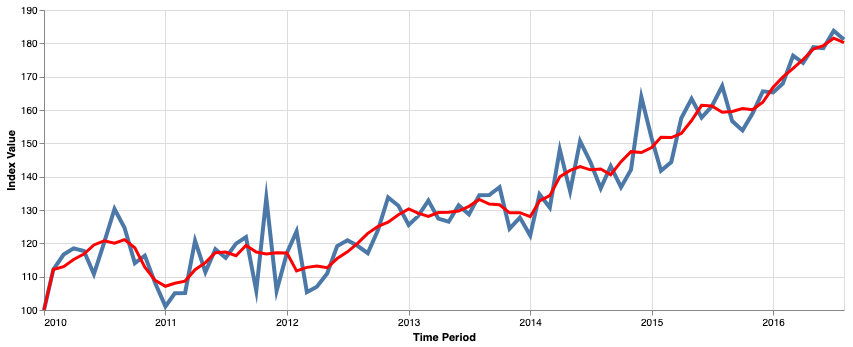

In [40]:
plot_index(hed_3, smooth=True)

## Analyzing an index

In [41]:
rt_hpi = RepeatTransactionIndex.create_index(
    trans_data=sales_rtdata,
    estimator='base',
    log_dep=True,
    trim_model=False,
    max_period=84,
    smooth=True,
)

hed_hpi = HedonicIndex.create_index(
    trans_data=sales_hhdata,
    estimator='weighted',
    log_dep=True,
    trim_model=False,
    max_period=84,
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    weights=np.random.uniform(0, 1, size=len(sales_hhdata.trans_df)),
    smooth=True,
)

### Volatility

In [42]:
index_vol = volatility(index=hed_hpi.value, window=3)

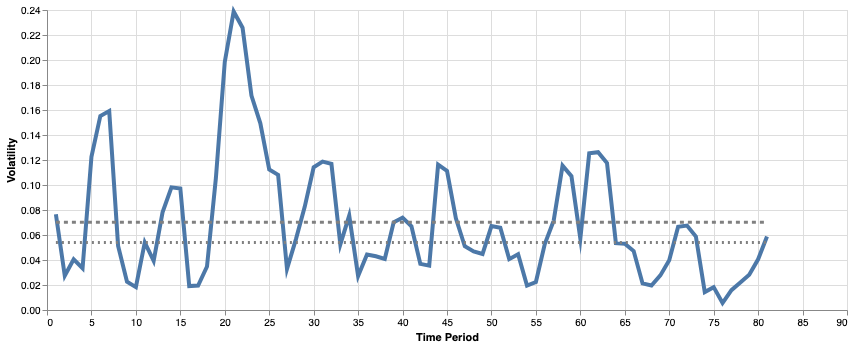

In [43]:
plot_index_volatility(index_vol)

In [44]:
index_vol = volatility(index=hed_hpi, window=3)

In [45]:
# Direct passing.
sindex_vol = volatility(index=hed_hpi.smooth, window=3)

# While passing 'HedonicIndex'.
sindex_vol = volatility(index=hed_hpi, window=3, smooth=True)

In [46]:
# Add it to the index attribute.
hed_hpi.index = volatility(index=hed_hpi, window=3, in_place=True)

# Add it to the full (HedonicIndex) object.
hed_hpi = volatility(index=hed_hpi, window=3, in_place=True)

In [47]:
hed_hpi = volatility(index=hed_hpi, window=3, in_place=True, smooth=True)

In [48]:
hed_index = volatility(index=hed_hpi, window=3, in_place=True)

### Fitting Accuracy (Index)

In [49]:
rt_is_accr = accuracy(hpi_obj=rt_hpi, test_type='rt', test_method='insample')

In [50]:
rt_is_accr = accuracy(hpi_obj=rt_hpi, test_type='rt', test_method='insample', smooth=True)

In [51]:
rt_kf_accr = accuracy(hpi_obj=rt_hpi, test_type='rt', test_method='kfold', k=10, seed=123)

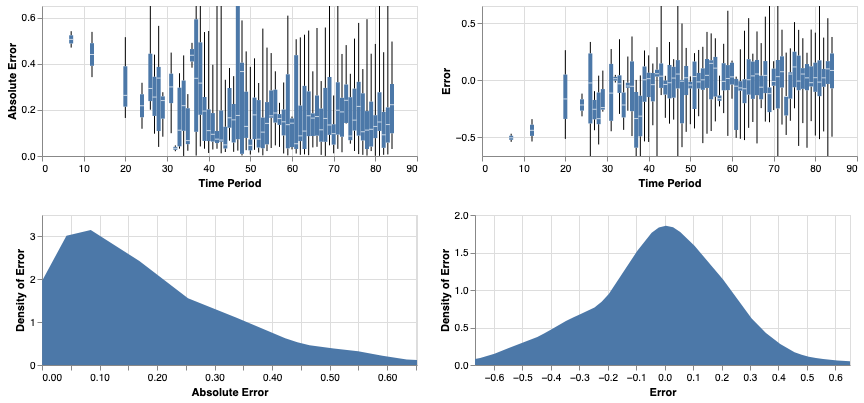

In [52]:
plot_index_accuracy(rt_kf_accr, size=4)

## Index Series

In [53]:
rt_series = rt_hpi.create_series(train_period=24, max_period=30)

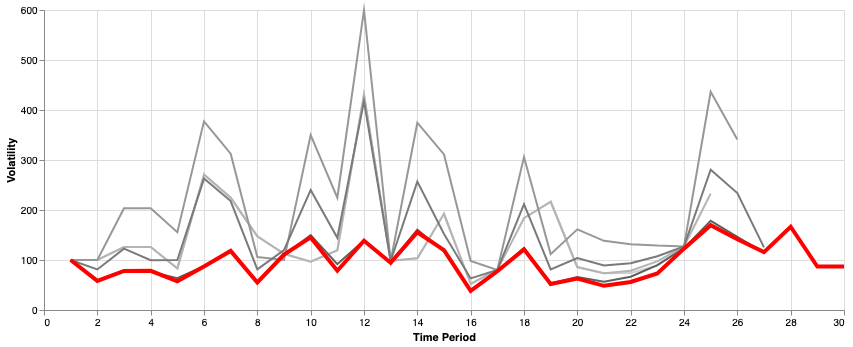

In [54]:
plot_series_volatility(rt_series)

### Series Analysis

In [55]:
rt_series = rt_series.smooth_series(order=5)

In [56]:
rt_series = series_volatility(series_obj=rt_series, window=3, smooth=True)

In [57]:
rt_sacc = series_accuracy(series_obj=rt_series, test_method='insample', test_type='rt')

In [58]:
rt_series = series_accuracy(
    series_obj=rt_series,
    test_method='kfold',
    test_type='rt',
    smooth=True,
    in_place=True,
)

In [59]:
series_acc_summ = series_accuracy(
    series_obj=rt_series,
    test_method='insample',
    test_type='rt',
    summarize=True,
)

### Forecast Accuracy

In [60]:
rt_series = series_accuracy(
    series_obj=rt_series,
    test_method='forecast',
    test_type='rt',
    smooth=True,
    in_place=True,
)

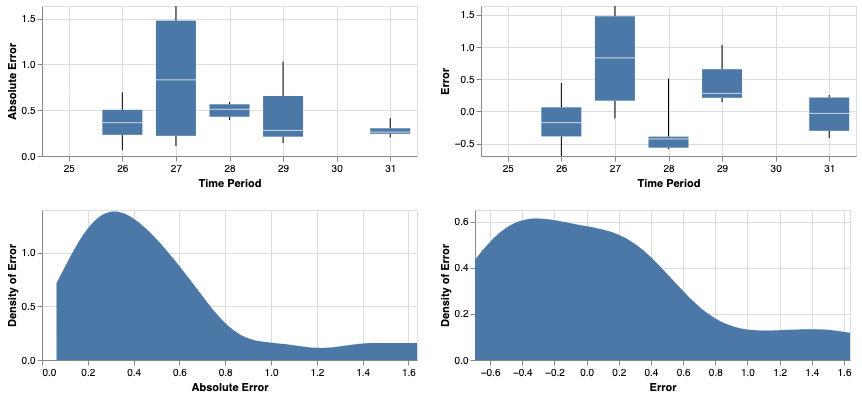

In [61]:
plot_index_accuracy(rt_series.accuracy_smooth, size=40)

### Revision

In [62]:
rt_rev = revision(rt_series)

In [63]:
rt_series = revision(rt_series, in_place=True, smooth=True)

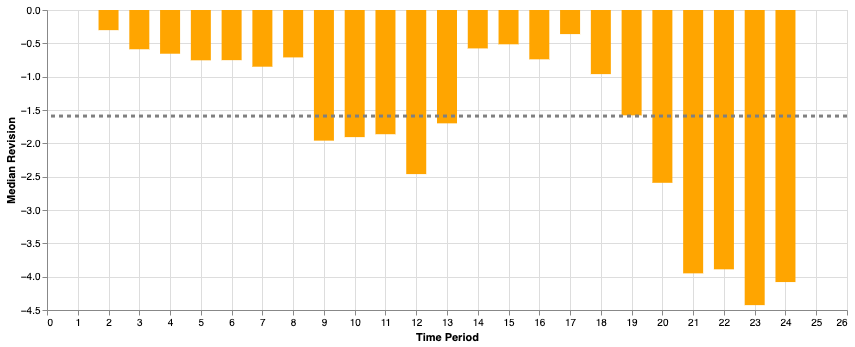

In [64]:
plot_series_revision(rt_series, smooth=True)

## Random Forest

In [65]:
rf_index = RandomForestIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    estimator='pdp',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    smooth=False,
    sim_ids=None,
    n_estimators=10,
)

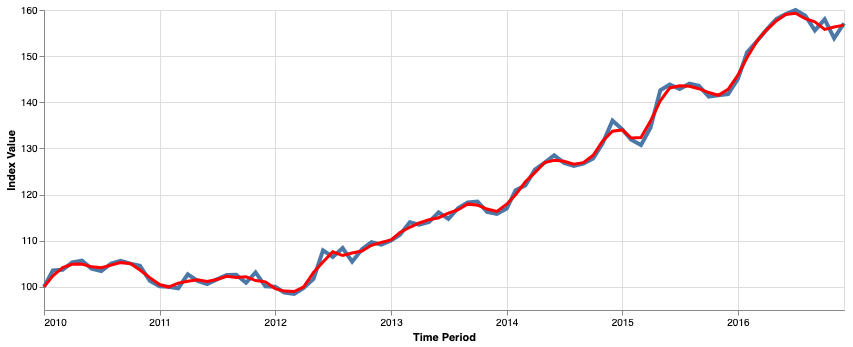

In [66]:
plot_index(rf_index.smooth_index(in_place=True), smooth=True)

In [67]:
rf_series = rf_index.create_series(train_period=24, max_period=30)

In [68]:
rf_series = rf_series.smooth_series(order=5)

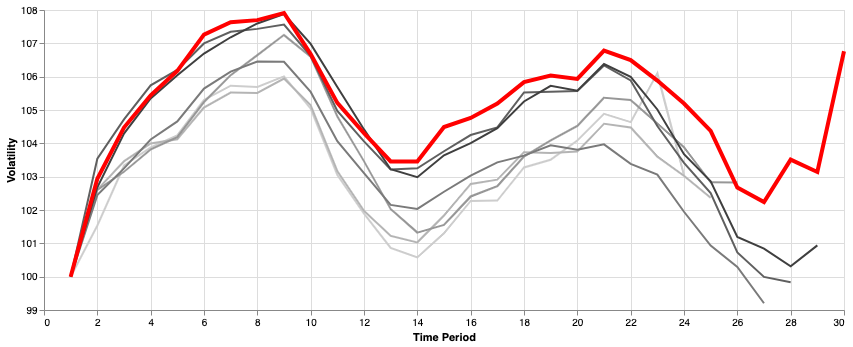

In [69]:
plot_series_volatility(rf_series, smooth=True)

In [70]:
rf_series = revision(rf_series, in_place=True, smooth=True)

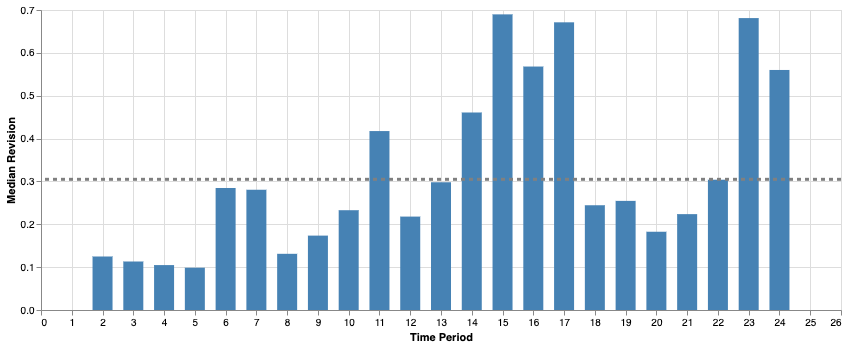

In [71]:
plot_series_revision(rf_series, smooth=True).interactive()

## Neural Network

In [72]:
nn_index = NeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='residual',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

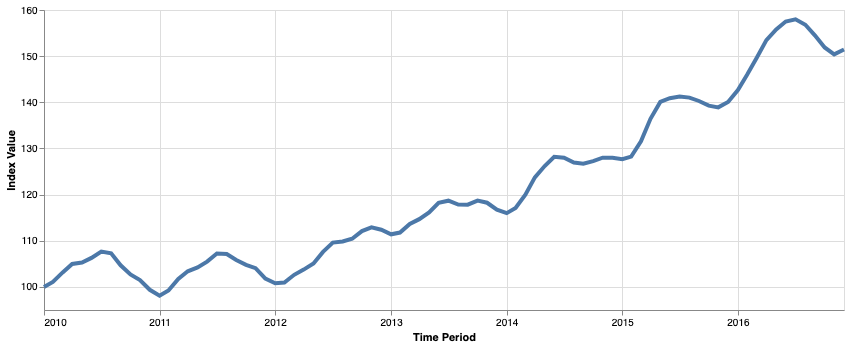

In [73]:
plot_index(nn_index)

In [74]:
nn_index = NeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='attributional',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

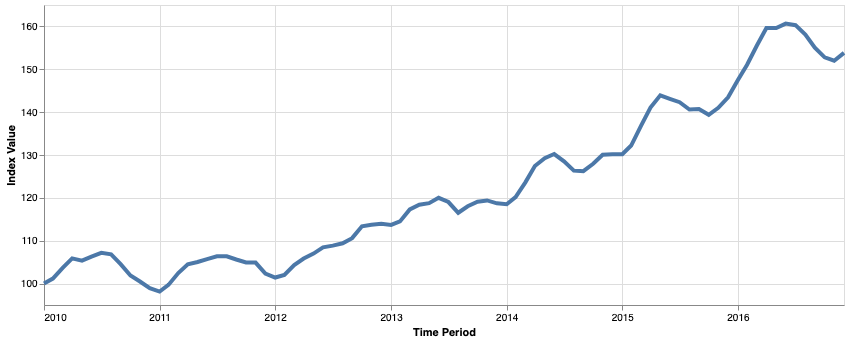

In [75]:
plot_index(nn_index)

In [76]:
nn_series = nn_index.create_series(train_period=24, max_period=30)

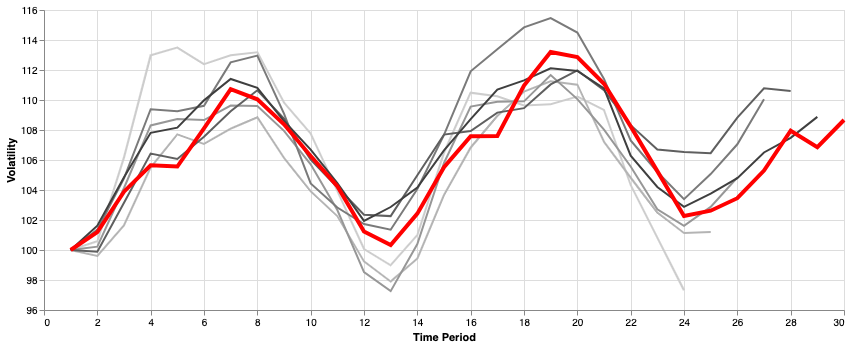

In [77]:
plot_series_volatility(nn_series, smooth=False)

In [78]:
nn_series = revision(nn_series, in_place=True, smooth=False)

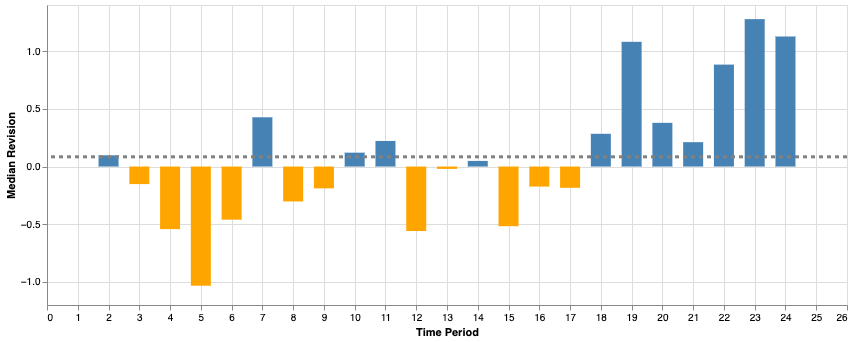

In [79]:
plot_series_revision(nn_series, smooth=False)

In [80]:
gnn_index = GraphNeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='residual',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

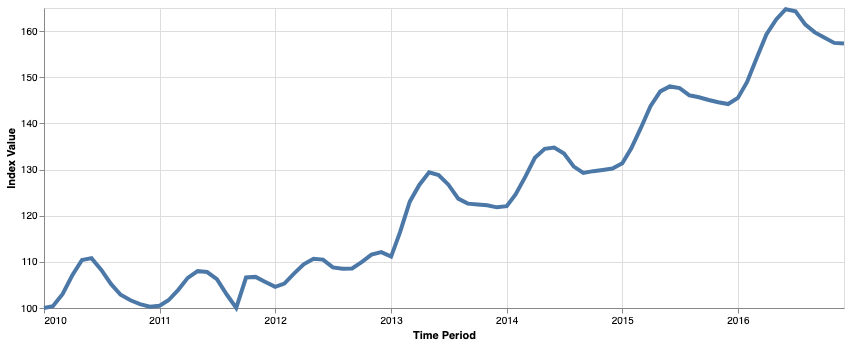

In [81]:
plot_index(gnn_index)

In [82]:
gnn_index = GraphNeuralNetworkIndex.create_index(
    sales_hhdata,
    date='sale_date',
    price='sale_price',
    trans_id='sale_id',
    prop_id='pinx',
    periodicity='monthly',
    dep_var='price',
    ind_var=['tot_sf', 'beds', 'baths'],
    estimator='attributional',
    preprocess_geo=False,
    feature_dict={
        'numerics': [],
        'log_numerics': ['tot_sf'],
        'categoricals': [],
        'ordinals': ['beds', 'baths'],
        'hpi': ['sale_date']
    },
)

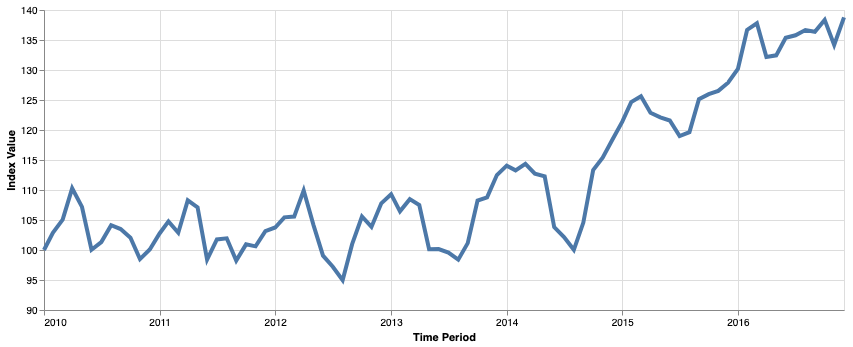

In [83]:
plot_index(gnn_index)